##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Ways to improve a model

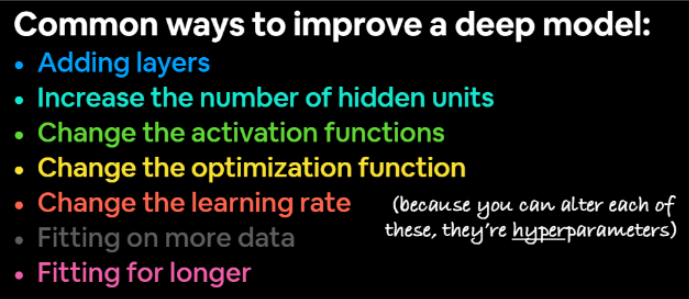

## Setup

In [ ]:
#!pip install -q -U tensorflow
#!pip install -q tensorflow_datasets

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(15, 5))
  # Plot loss
  plt.subplot(1, 2, 1)
  plt.title('Loss')
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.title('Accuracy')
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](../load_data/text.ipynb) for details on how to load this sort of data manually.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGKR3VS/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGKR3VS/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGKR3VS/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

25000
25000


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"one may ask why? the characters snarl, yell, and chew the scenery without any perceptible reason except someone wanted to make a movie in barcelona. billie baldwin, is that the right one?, is forgettable in the cop/estranged-husband/loving-father-of-cute-little-blond-girl role. the story seems to have been cut and pasted from the scenes thrown away from adventure films in the last three years. ellen pompeo's lack of charisma is a black hole that seems to suck the energy out of every scene she is in. her true acting range is displayed when she takes her blouse off as the movies careens from one limp chase scene to another. unfortunately, the directing rarely goes bad enough to be camp or a parody. it is all just clich\xc3\xa9, familiar in every respect. the director cast his own daughter as the precocious brat probably because no respectable agent would have permitted a client to ruin a career by being in such a lame, contrived and uninteresting movie. the only heist here is 

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
# Find average number of tokens (words) in training Tweets
round(sum([len(example.numpy()[0].split()) for example, label in train_dataset])/len(train_dataset))

254

In [ ]:
# Setup text vectorization with custom variables
max_vocab_length = 1000  # max number of words to have in our vocabulary
max_length = 256 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

encoder = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                            output_mode="int",
                                            output_sequence_length=max_length
                                    )

# Training the encoder
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 29, 194, 915, 134,   2, 102,   1,   1,   3,   1,   2,   1, 201,
         99,   1, 275, 542, 283, 453,   6,  94,   4,  18,   8,   1,   1,
          1,   7,  12,   2, 205,  29,   7,   1,   8,   2,   1, 214,   2,
         64, 181,   6,  26,  75, 643,   3,   1,  36,   2, 137,   1, 242,
         36,   1,  95,   8,   2, 226, 290, 148,   1,   1, 559,   5,   1,
          7,   4, 323,   1,  12, 181,   6,   1,   2,   1,  46,   5, 168,
        135,  55,   7,   8,  40, 281, 112,   1,   7,   1,  51,  55, 292,
         40,   1, 127,  15,   2,  93,   1,  36,  29,   1,   1, 135,   6,
        154, 459,   2, 929,   1, 261,  84, 190,   6,  28,   1,  42,   4,
          1,   9,   7,  32,  41,   1,   1,   8, 168,   1,   2, 172, 177,
         25, 200, 580,  15,   2,   1,   1, 235,  80,  57,   1,   1,  59,
         26,   1,   4,   1,   6,   1,   4, 623,  33, 107,   8, 136,   4,
        836,   1,   3,   1,  18,   2,  61,   1, 132,   7,   2,   1,   5,
          2,   1, 276,   3,   2, 722,  62,   0,   0

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"one may ask why? the characters snarl, yell, and chew the scenery without any perceptible reason except someone wanted to make a movie in barcelona. billie baldwin, is that the right one?, is forgettable in the cop/estranged-husband/loving-father-of-cute-little-blond-girl role. the story seems to have been cut and pasted from the scenes thrown away from adventure films in the last three years. ellen pompeo's lack of charisma is a black hole that seems to suck the energy out of every scene she is in. her true acting range is displayed when she takes her blouse off as the movies careens from one limp chase scene to another. unfortunately, the directing rarely goes bad enough to be camp or a parody. it is all just clich\xc3\xa9, familiar in every respect. the director cast his own daughter as the precocious brat probably because no respectable agent would have permitted a client to ruin a career by being in such a lame, contrived and uninteresting movie. the only heist here i

## Create the model

In [ ]:
# Set random seed
tf.random.set_seed(42)

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), #from_logits=True
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 256)              0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 256, 64)           64000     
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-tr

## Train the model

In [ ]:
# Set random seed
tf.random.set_seed(42)

# O parâmetro patience é o quantidade de epochs para checar as melhoras
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Callback to save the best weights during training process
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True
  )

# Fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=32,
                    callbacks=[model_checkpoint_callback, early_stop],
                    verbose=1)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


391/391 [==============================] - 24s 42ms/step - loss: 0.6324 - accuracy: 0.6361 - val_loss: 0.4881 - val_accuracy: 0.7920
Epoch 2/10
391/391 [==============================] - 17s 41ms/step - loss: 0.4212 - accuracy: 0.8174 - val_loss: 0.4130 - val_accuracy: 0.8286
Epoch 3/10
391/391 [==============================] - 14s 35ms/step - loss: 0.3692 - accuracy: 0.8437 - val_loss: 0.3693 - val_accuracy: 0.8423
Epoch 4/10
391/391 [==============================] - 15s 37ms/step - loss: 0.3464 - accuracy: 0.8551 - val_loss: 0.3602 - val_accuracy: 0.8452
Epoch 5/10
391/391 [==============================] - 17s 43ms/step - loss: 0.3377 - accuracy: 0.8575 - val_loss: 0.3583 - val_accuracy: 0.8481
Epoch 6/10
391/391 [==============================] - 16s 40ms/step - loss: 0.3308 - accuracy: 0.8604 - val_loss: 0.3493 - val_accuracy: 0.8486
Epoch 7/10
391/391 [==============================] - 16s 41ms/step - loss: 0.3264 - accuracy: 0.8638 - val_loss: 0.3591 - val_accuracy: 0.8418
Epo

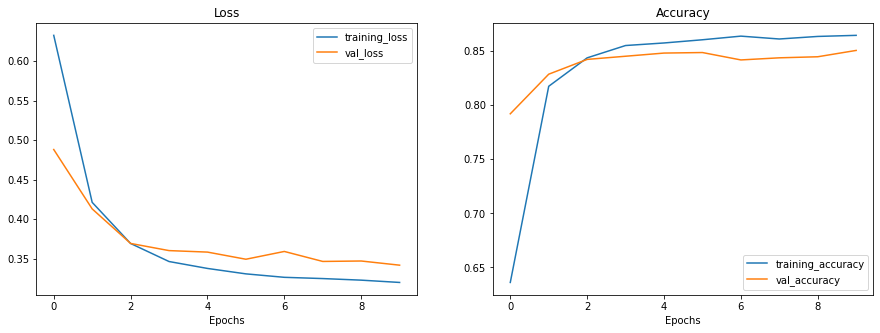

In [ ]:
plot_loss_curves(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 8s 22ms/step - loss: 0.3427 - accuracy: 0.8474
Test Loss: 0.342658132314682
Test Accuracy: 0.8474000096321106


Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/layered_bidirectional.ipynb?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
# Set random seed
tf.random.set_seed(42)

# O parâmetro patience é o quantidade de epochs para checar as melhoras
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Callback to save the best weights during training process
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True
  )

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


# Fit the model
history_2 = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=32,
                    callbacks=[model_checkpoint_callback, early_stop],
                    verbose=1)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/10
391/391 [==============================] - 44s 77ms/step - loss: 0.6134 - accuracy: 0.5994 - val_loss: 0.4271 - val_accuracy: 0.8091
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3936 - accuracy: 0.8228 - val_loss: 0.3710 - val_accuracy: 0.8223
Epoch 3/10
391/391 [==============================] - 29s 71ms/step - loss: 0.3540 - accuracy: 0.8439 - val_loss: 0.3582 - val_accuracy: 0.8340
Epoch 4/10
391/391 [==============================] - 28s 70ms/step - loss: 0.3398 - accuracy: 0.8495 - val_loss: 0.3478 - val_accuracy: 0.8418
Epoch 5/10
391/391 [==============================] - 28s 70ms/step - loss: 0.3375 - accuracy: 0.8527 - val_loss: 0.3545 - val_accuracy: 0.8481
Epoch 6/10
391/391 [==============================] - 28s 70ms/step - loss: 0.3310 - accuracy: 0.8567 - val_loss: 0.3818 - val_accuracy: 0.8477
Epoch 7/10
391/391 [==============================] - 29s 73ms/step - loss: 0.3294 - accuracy: 0.8574 - val_loss: 0.3565 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 13s 34ms/step - loss: 0.3522 - accuracy: 0.8488
Test Loss: 0.35215282440185547
Test Accuracy: 0.8488399982452393


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.575666]]


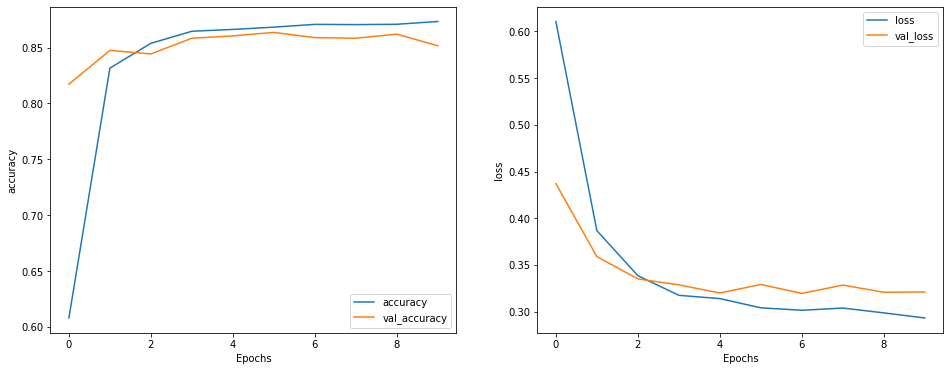

In [ ]:
plot_loss_curves(history_2)

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
